In [1]:
import sys
import pandas as pd 
sys.path.insert(0, '/home/bekah/gPhoton2')
from gPhoton.pipeline import execute_pipeline
from astropy.io import fits
from io import BytesIO
import numpy as np 
import os
import matplotlib.pyplot as plt
from gPhoton.coadd import zero_flag_and_edge
import pyarrow.parquet as parquet
from quickbin import bin2d


In [ ]:
eclipses = pd.read_csv("/home/bekah/glcat/masks/every3_fuv.csv")

In [ ]:
eclipses = eclipses[1000:1200]

In [ ]:
eclipses

In [ ]:
for index, eclipse in eclipses['eclipse'].items():
    print(eclipse)
    try: 
        execute_pipeline(
                14112 ,#int(eclipse),
                "FUV",
                depth=None,
                # integer; None to deactivate (default None)
                threads=4,
                # where to both write output data and look for input data
                local_root="/media/bekah/BekahA/background_test/pics_and_photonlists",
                # auxiliary remote location for input data
                # remote_root="/mnt/s3",
                recreate=True,
                # list of floats; relevant only to lightcurve / photometry portion
                aperture_sizes=[12.8],
                # actually write image/movie products? otherwise hold in memory but
                # discard (possibly after performing photometry).
                write={"movie": False, "image": False},
                coregister_lightcurves=False,
                # photonpipe, moviemaker, None (default None)
                stop_after=None,
                photometry_only=False,
                # None, "gzip", "rice"
                compression="rice",
                # use array sparsification on movie frames?
                lil=False,
                # write movie frames as separate files
                burst=False,
                extended_photonlist=True,
                # aspect file, don't need to set unless need to use alt
                # file, 'aspect2.parquet'
            )
        
         # photon table would already exist in gphoton2 
        photons = parquet.read_table(f"/media/bekah/BekahA/background_test/pics_and_photonlists/e{eclipse}/e{eclipse}-nd-b00.parquet", 
                                     columns=['ra','dec','col','row','q','flags','detrad','t']).to_pandas()

        # want photons that are on detector, no flags, has aspect soln 
        photons = photons[(photons['detrad'] < 600)]
        photons = photons.dropna(subset=['ra', 'dec'])
        photons = photons[(photons['flags'] < 1)]

        # bin2d for ra & dec std + count, also get vals for q range 
        ra = bin2d(photons['col'],photons['row'],photons['ra'],n_bins=800,op=('count', 'std'))
        dec = bin2d(photons['col'],photons['row'],photons['dec'],n_bins=800,op=('std'))
        q_m =  bin2d(photons['col'],photons['row'],photons['q'],n_bins=800,op=('min', 'max'))

        # dispersion metric 
        disp = ra['std']+dec # bin2d only returns a dictionary when more than one stat is calculated 

        # rough exp time (use the correct one for threshold calc)
        time = abs(photons['t'].iloc[0]-photons['t'].iloc[-1])

        fig, axs = plt.subplots(2, 2, figsize=(10, 8))

        axs[0,0].scatter(disp,ra['count']/time,s=.1)
        axs[0,0].set_ylabel("total photons per bin div by expt")
        axs[0,0].set_xlabel('dispersion per bin')

        axs[1,0].hist(np.ravel(disp))
        axs[1,0].set_xlabel("dispersion")

        axs[0,1].imshow(disp)
        axs[0,1].set_xlabel("dispersion")

        axs[1,1].imshow(q_m['max']-q_m['min'])
        axs[1,1].set_xlabel('q range')

        plt.tight_layout()
        plt.savefig(f'/media/bekah/BekahA/background_test/e{eclipse}_fuv.png')
    except Exception as e: 
        print(e)


In [ ]:
# so I want to show the current (background rms) method for threshold as well as other ways 
# other ways include: 
# using dispersion as the metric
# but how do I turn that into a map? 

In [2]:
from astropy.io import fits
from io import BytesIO
import numpy as np 
import os
import matplotlib.pyplot as plt
from gPhoton.coadd import zero_flag_and_edge
import pyarrow.parquet as parquet

In [ ]:
from quickbin import bin2d
import pyarrow.parquet as parquet
import pandas as pd 

# photon table would already exist in gphoton2 
photons = parquet.read_table("/media/bekah/BekahA/background_test/e00580/e00580-nd-b00.parquet", 
                             columns=['ra','dec','col','row','q','flags','detrad','t']).to_pandas()

# want photons that are on detector, no flags, has aspect soln 
photons = photons[(photons['detrad'] < 600)]
photons = photons.dropna(subset=['ra', 'dec'])
photons = photons[(photons['flags'] < 1)]

# bin2d for ra & dec std + count, also get vals for q range 
ra = bin2d(photons['col'],photons['row'],photons['ra'],n_bins=800,op=('count', 'std'))
dec = bin2d(photons['col'],photons['row'],photons['dec'],n_bins=800,op=('std'))
q_m =  bin2d(photons['col'],photons['row'],photons['q'],n_bins=800,op=('min', 'max'))

# dispersion metric 
disp = ra['std']+dec # bin2d only returns a dictionary when more than one stat is calculated 

# rough exp time (use the correct one for threshold calc)
time = abs(photons['t'].iloc[0]-photons['t'].iloc[-1])


In [ ]:
ra

In [ ]:
# getting threshold 
high_disp = np.argwhere(disp>.013)
values = ra['count'][high_disp[:, 0], high_disp[:, 1]]
max(values/time)*.5

In [ ]:
# getting threshold 
high_disp = np.argwhere(disp<.0025)
values = ra['count'][high_disp[:, 0], high_disp[:, 1]]
max(values/time)*.5

In [ ]:
# fig 1: DISPERSION 
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0,0].scatter(disp,ra['count']/time,s=.1)
axs[0,0].set_ylabel("total photons per bin div by expt")
axs[0,0].set_xlabel('dispersion per bin')

axs[1,0].hist(disp)
axs[1,0].set_xlabel("dispersion")

axs[0,1].imshow(disp)
axs[0,1].set_xlabel("dispersion")

axs[1,1].imshow(q_m['max']-q_m['min'])
axs[1,1].set_xlabel('q range')

plt.tight_layout()
plt.savefig(f'/media/bekah/BekahA/background_test/{eclipse}_nuv.png')

In [ ]:
plt.hist(disp)
plt.xlabel("dispersion")

In [ ]:
800*800

In [ ]:
# getting eclipse list
import re
main_folder = '/media/bekah/BekahA/background_test/pics_and_photonlists'
folders = [
    f for f in os.listdir(main_folder) 
    if os.path.isdir(os.path.join(main_folder, f)) and re.search(r'\d', f)]
eclipses = [folder.replace('e', '') for folder in folders]

In [ ]:
len(eclipses)

In [ ]:
# putting it all together 
from quickbin import bin2d
import pyarrow.parquet as parquet
import pandas as pd 

for eclipse in eclipses: 
    # photon table would already exist in gphoton2 
    photons = parquet.read_table(f"/media/bekah/BekahA/background_test/pics_and_photonlists/e{eclipse}/e{eclipse}-nd-b00.parquet", 
                                 columns=['ra','dec','col','row','q','flags','detrad','t']).to_pandas()

    # want photons that are on detector, no flags, has aspect soln 
    photons = photons[(photons['detrad'] < 600)]
    photons = photons.dropna(subset=['ra', 'dec'])
    photons = photons[(photons['flags'] < 1)]

    # bin2d for ra & dec std + count, also get vals for q range 
    ra = bin2d(photons['col'],photons['row'],photons['ra'],n_bins=800,op=('count', 'std'))
    dec = bin2d(photons['col'],photons['row'],photons['dec'],n_bins=800,op=('std'))
    q_m =  bin2d(photons['col'],photons['row'],photons['q'],n_bins=800,op=('min', 'max'))

    # dispersion metric 
    disp = ra['std']+dec # bin2d only returns a dictionary when more than one stat is calculated 

    # rough exp time (use the correct one for threshold calc)
    time = abs(photons['t'].iloc[0]-photons['t'].iloc[-1])

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    axs[0,0].scatter(disp,ra['count']/time,s=.1)
    axs[0,0].set_ylabel("total photons per bin div by expt")
    axs[0,0].set_xlabel('dispersion per bin')

    axs[1,0].hist(np.ravel(disp))
    axs[1,0].set_xlabel("dispersion")

    axs[0,1].imshow(disp)
    axs[0,1].set_xlabel("dispersion")

    axs[1,1].imshow(q_m['max']-q_m['min'])
    axs[1,1].set_xlabel('q range')

    plt.tight_layout()
    plt.savefig(f'/media/bekah/BekahA/background_test/e{eclipse}_fuv.png')


In [ ]:
special_eclipses = ['00587','00826','00767','14182']

from quickbin import bin2d

for eclipse in special_eclipses: 
    # photon table would already exist in gphoton2 
    photons = parquet.read_table(f"/media/bekah/BekahA/background_test/pics_and_photonlists/e{eclipse}/e{eclipse}-nd-b00.parquet", 
                                 columns=['ra','dec','col','row','q','flags','detrad','t']).to_pandas()

    # want photons that are on detector, no flags, has aspect soln 
    photons = photons[(photons['detrad'] < 600)]
    photons = photons.dropna(subset=['ra', 'dec'])
    photons = photons[(photons['flags'] < 1)]

    # bin2d for ra & dec std + count, also get vals for q range 
    ra = bin2d(photons['col'],photons['row'],photons['ra'],n_bins=800,op=('count', 'std'))
    dec = bin2d(photons['col'],photons['row'],photons['dec'],n_bins=800,op=('std'))
    q_m =  bin2d(photons['col'],photons['row'],photons['q'],n_bins=800,op=('min', 'max'))

    # dispersion metric 
    disp = ra['std']+dec # bin2d only returns a dictionary when more than one stat is calculated 

    hdu1 = fits.PrimaryHDU(disp)
    hdu2 = fits.ImageHDU(ra['count'])
    hdulist = fits.HDUList([hdu1, hdu2])
    hdulist.writeto(f'e{eclipse}_hists.fits', overwrite=True)
    print(f"done w {eclipse}")

In [4]:
from quickbin import bin2d

eclipse = '14112'

# photon table would already exist in gphoton2 
photons = parquet.read_table(f"/media/bekah/BekahA/background_test/pics_and_photonlists/e{eclipse}/e{eclipse}-fd-b00.parquet", 
                             columns=['ra','dec','col','row','q','flags','detrad','t']).to_pandas()

# want photons that are on detector, no flags, has aspect soln 
photons = photons[(photons['detrad'] < 600)]
photons = photons.dropna(subset=['ra', 'dec'])
photons = photons[(photons['flags'] < 1)]

# bin2d for ra & dec std + count, also get vals for q range 
ra = bin2d(photons['col'],photons['row'],photons['ra'],n_bins=800,op=('count', 'std'))
dec = bin2d(photons['col'],photons['row'],photons['dec'],n_bins=800,op=('std'))
q_m =  bin2d(photons['col'],photons['row'],photons['q'],n_bins=800,op=('min', 'max'))

# dispersion metric 
disp = ra['std']+dec # bin2d only returns a dictionary when more than one stat is calculated 

metric1 = disp / ra['count']
metric2 = ra['count'] / disp
metric3 = ra['count'] * disp

In [5]:
SEM = disp / np.sqrt(ra['count'])

(array([3.9450e+03, 1.4700e+02, 1.2500e+02, 9.6000e+01, 1.0400e+02,
        9.8000e+01, 1.0000e+02, 1.1300e+02, 1.0100e+02, 8.9000e+01,
        1.3100e+02, 1.0900e+02, 1.2200e+02, 1.5500e+02, 1.6100e+02,
        1.8500e+02, 2.2700e+02, 2.6600e+02, 3.5300e+02, 4.6600e+02,
        5.6400e+02, 6.8900e+02, 7.5300e+02, 9.2100e+02, 1.2710e+03,
        1.7870e+03, 3.0640e+03, 4.9620e+03, 7.6330e+03, 1.1063e+04,
        1.5350e+04, 1.9596e+04, 2.3572e+04, 2.6640e+04, 2.8811e+04,
        3.0076e+04, 2.9935e+04, 2.9059e+04, 2.7991e+04, 2.5887e+04,
        2.4183e+04, 2.2032e+04, 1.9865e+04, 1.7664e+04, 1.5700e+04,
        1.4008e+04, 1.2183e+04, 1.0605e+04, 9.3270e+03, 7.8050e+03,
        6.9190e+03, 6.1160e+03, 5.2190e+03, 4.4920e+03, 3.8640e+03,
        3.5230e+03, 3.1110e+03, 2.5730e+03, 2.0710e+03, 1.8410e+03,
        1.5570e+03, 1.4150e+03, 1.3800e+03, 1.1950e+03, 1.0020e+03,
        7.7400e+02, 6.8000e+02, 5.9300e+02, 5.1400e+02, 4.6100e+02,
        4.7600e+02, 4.2200e+02, 3.5100e+02, 3.19

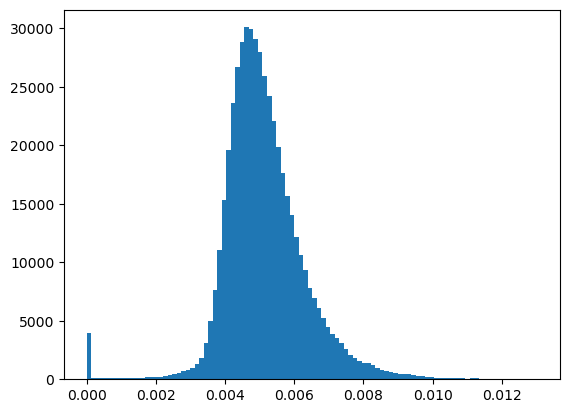

In [18]:
plt.hist(np.ravel(SEM),bins=100)

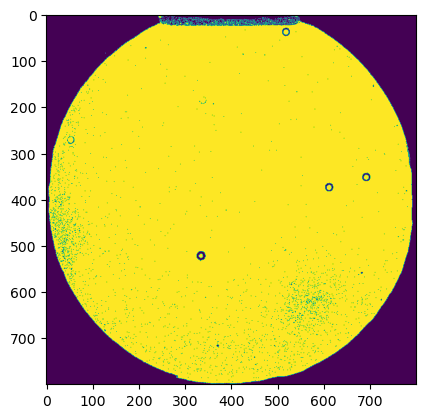

In [23]:
plt.imshow(SEM > .002)

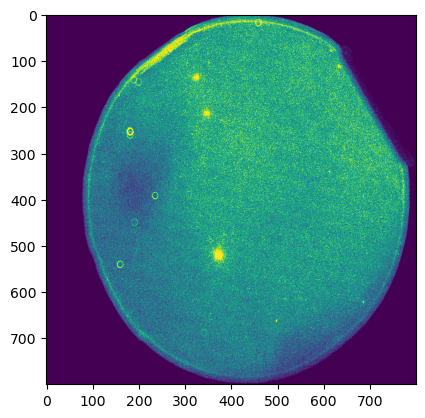

In [12]:
cnt = bin2d(photons['ra'],photons['dec'],photons['ra'],n_bins=800,op=('count', 'std'))

plt.imshow(centile_clip(cnt['count']))

(array([6.39963e+05, 1.90000e+01, 2.00000e+00, 1.00000e+00, 2.00000e+00,
        1.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

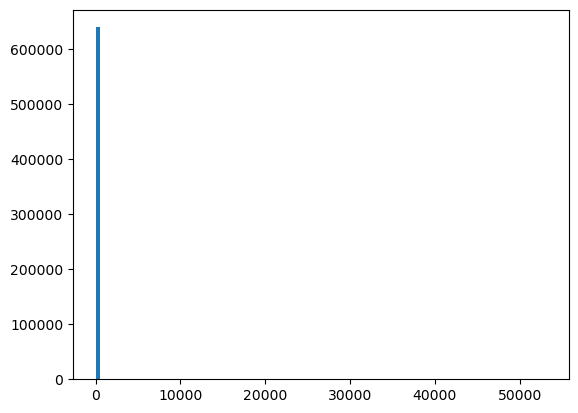

In [26]:
plt.hist(np.ravel(cnt['count']),bins=100)

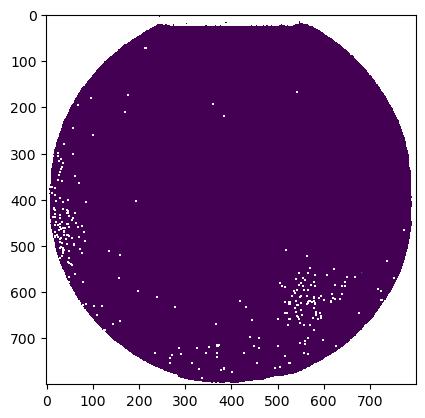

In [8]:
plt.imshow(metric3)

In [ ]:
metric2 = np.where(np.isnan(metric2), 0, metric2)
metric2[metric2 > 1e308] = 0

In [ ]:
np.min(metric2)

In [ ]:
type(metric2)

In [ ]:
metric2

In [ ]:
hdu1 = fits.PrimaryHDU()
hdu3 = fits.ImageHDU(SEM)
hdu2 = fits.ImageHDU(metric3)
hdulist = fits.HDUList([hdu1, hdu2, hdu3])
hdulist.writeto(f'e{eclipse}_metrics.fits', overwrite=True)

In [ ]:
# checking threshold map 

e4112 = fits.open("/media/bekah/BekahA/background_test/e14112_FUV_threshold.fits")

In [10]:
def centile_clip(image, centiles=(1, 99)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

In [ ]:
plt.imshow(e4112[1].data>e4112[3].data)

In [ ]:
plt.imshow(centile_clip(e4112[3].data))

In [ ]:
e4112_nosub = fits.open("/media/bekah/BekahA/background_test/e14112_FUV_threshold_nobkgsub.fits")

In [ ]:
fig, ax = plt.subplots()
plt.imshow(e4112_nosub[1].data>e4112_nosub[3].data)
ax.invert_yaxis()

In [ ]:
plt.imshow(centile_clip(e4112_nosub[1].data))

In [ ]:
from photutils.background import Background2D, MedianBackground
from astropy.stats import SigmaClip


In [ ]:
cnt_image = e4112_nosub[1].data
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(cnt_image,
                       (50, 50),
                       filter_size=(3, 3),
                       bkg_estimator=bkg_estimator,
                       sigma_clip=sigma_clip),
                       mask=e4112_nosub[4].data.astype(bool))

In [ ]:
plt.imshow(bkg.background)

In [ ]:
bkg.background.shape

In [ ]:
bkg2.background.shape

In [ ]:
plt.imshow(bkg.background_rms.astype(np.float32))


In [ ]:
plt.imshow(np.multiply(3,bkg.background_rms),interpolation=None,cmap='grey')


In [ ]:
fig, ax = plt.subplots()
plt.imshow(np.multiply(3,bkg2.background_rms),interpolation=None,cmap='grey')
ax.invert_yaxis()

In [ ]:

fig, ax = plt.subplots()
plt.imshow(e4112[1].data>np.multiply(3,bkg2.background_rms))
ax.invert_yaxis()

In [ ]:
bkg2 = Background2D(cnt_image,
                       (50, 50),
                       filter_size=(3, 3),
                       bkg_estimator=bkg_estimator)

plt.imshow(bkg2.background)
plt.colorbar()

In [ ]:
plt.imshow(e4112_nosub[4].data)
plt.colorbar()

In [ ]:
type(e4112_nosub[4].data)